<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/LanguageModelFastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

In [31]:
# check installed version
!pip freeze | grep -E "torch|fastai"

fastai==1.0.61
torch==1.8.1+cu101
torchsummary==1.5.1
torchtext==0.9.1
torchvision==0.9.1+cu101


In [32]:
from google.colab import drive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from fastai.text import *

### Mount Google Drive

We will store all model in Google Drive

In [34]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Download Data

In [35]:
!mkdir -p data
!wget https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O data/train.csv
!wget https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O data/test.csv
!ls -lAh data

2021-04-19 21:33:12 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "data/train.csv" [1]
2021-04-19 21:33:13 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "data/test.csv" [1]
total 53M
-rw-r--r-- 1 root root  27M Apr 19 21:22 10kgnad__lm.pkl
-rw-r--r-- 1 root root 2.7M Apr 19 21:33 test.csv
-rw-r--r-- 1 root root  24M Apr 19 21:33 train.csv


## Load Data

In [92]:
root_path = Path("/content/gdrive/My Drive/")
drive_path = root_path / "Colab Notebooks/nlp-classification/"
model_path = drive_path / "model/"

data_path = Path("data/")

train_file = data_path / "train.csv"
test_file = data_path / "test.csv"

In [37]:
def load_file(filepath: Path, columns: list=["labels", "text"]) -> pd.DataFrame:
    """Load dataset from CVS file."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

In [38]:
train_df = load_file(train_file).assign(is_valid=False)
valid_df = load_file(test_file).assign(is_valid=True)

# combine training and test data
text_df = pd.concat([train_df, valid_df], ignore_index=True)

print(text_df.shape[0], 'articles')
display(text_df.head())

10273 articles


,text,is_valid
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,False
1,"Erfundene Bilder zu Filmen, die als verloren g...",False
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,False
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",False
4,Estland sieht den künftigen österreichischen P...,False


## Data Preparation

In [39]:
# truncate text
#text_df.text = text_df.text.map(lambda x: x[:2000])

In [50]:
# define batchsize
batchsize=128

lm_databunch_path = drive_path / "data" / "10kgnad__lm.pkl"

In [68]:
def prepare_databunch_lm(lm_path: Path, df: pd.DataFrame, bs: int) -> DataBunch:
    """Load or create text databunch for language model training."""

    # check if databunch already exists
    if lm_path.is_file():
        print("loading preprocessed text data")
        return load_data(lm_path.parent, lm_path.name, bs=bs)

    else:
        print("processing text data")
        data_lm = (TextList
                   .from_df(text_df, cols='text')
                   .split_from_df(col='is_valid')
                   .label_for_lm()
                   .databunch(bs=bs)
                   )
        data_lm.save(lm_path)
        return data_lm

In [69]:
%%time
data_lm = prepare_databunch_lm(lm_databunch_path, text_df, batchsize)

print(f"{len(data_lm.vocab.itos):,} words in vocabulary")

processing text data


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


60,000 words in vocabulary
CPU times: user 5.55 s, sys: 855 ms, total: 6.4 s
Wall time: 8min 41s


In [70]:
data_lm

TextLMDataBunch;

Train: LabelList (9245 items)
x: LMTextList
xxbos 21-jähriger fällt wohl bis xxmaj saisonende aus . xxmaj wien – xxmaj rapid muss wohl bis xxmaj saisonende auf xxmaj offensivspieler xxmaj thomas xxmaj murg verzichten . xxmaj der i m xxmaj winter aus xxmaj ried gekommene 21-jährige erlitt beim xxunk gegen xxmaj admira xxmaj wacker xxmaj mödling am xxmaj samstag einen xxmaj teilriss des xxmaj xxunk i m linken xxmaj knie , wie eine xxmaj xxunk - xxmaj untersuchung am xxmaj donnerstag ergab . xxmaj murg erhielt eine xxmaj schiene , muss aber nicht operiert werden . xxmaj dennoch steht ihm eine xxunk xxmaj pause bevor .,xxbos xxmaj erfundene xxmaj bilder zu xxmaj filmen , die als verloren gelten : " xxmaj the xxmaj forbidden xxmaj room " von xxmaj guy xxmaj maddin und xxmaj evan xxmaj johnson ist ein xxunk xxmaj ritt durch die magischen xxmaj xxunk des frühen xxmaj kinos . xxmaj wien – xxmaj die xxmaj filmgeschichte ist ein xxmaj friedhof der xxmaj verlorenen . xxmaj unter

# Prepare German Language Model

Implementation follows this description https://forums.fast.ai/t/ulmfit-german/22529/110

In [91]:
! pip install -q wandb > /dev/null

In [106]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project = "German Language Model ULMFit");

epoch,2
train_loss,3.07686
valid_loss,3.21044
_runtime,2322
_timestamp,1618873235
_step,7
accuracy,0.42478


epoch,▁▁▁▁▅▅██
train_loss,█▂▁▁▁▁▁▁
_runtime,▁▃▅▅▆▆██
_timestamp,▁▃▅▅▆▆██
_step,▁▂▃▄▅▆▇█
valid_loss,█▄▄▁▁▁▁
accuracy,▁▅▅▇▇██


In [81]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150

# pretrained German language model
FILE_LM_ENCODER = drive_path / "model" / "30k-pre-ger"
FILE_ITOS = drive_path / "model" / "30k-pre-ger-itos"

In [82]:
%%time
learn = language_model_learner(data_lm,
                               AWD_LSTM,
                               config=config,
                               pretrained_fnames=[FILE_LM_ENCODER, FILE_ITOS],
                               drop_mult=0.3,
                               callback_fns=WandbCallback
                               )

CPU times: user 1.36 s, sys: 352 ms, total: 1.71 s
Wall time: 1.96 s


## Training Language Model: Top Layer

In [83]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


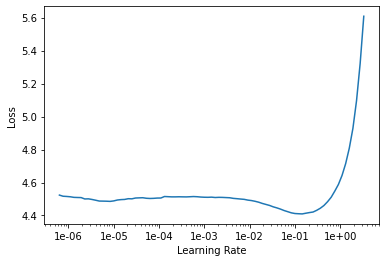

In [84]:
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.718726,3.415094,0.405070,08:12


Better model found at epoch 0 with valid_loss value: 3.4150938987731934.
Loaded best saved model from /content/wandb/run-20210419_222153-2c9mjpn9/files/bestmodel.pth


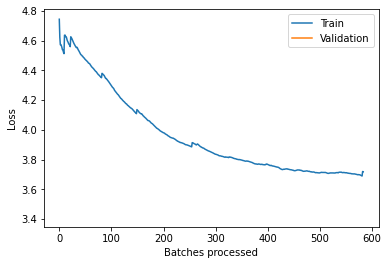

In [86]:
learn.recorder.plot_losses()

## Training Language Model: Fine tuning

In [87]:
learn.unfreeze()

In [88]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.326706,3.295168,0.416678,09:03
1,3.211934,3.224742,0.423103,09:03
2,3.076864,3.210444,0.424777,09:03


Better model found at epoch 0 with valid_loss value: 3.295167922973633.
Better model found at epoch 0 with valid_loss value: 3.295167922973633.
Better model found at epoch 1 with valid_loss value: 3.2247421741485596.
Better model found at epoch 1 with valid_loss value: 3.2247421741485596.
Better model found at epoch 2 with valid_loss value: 3.210444211959839.
Better model found at epoch 2 with valid_loss value: 3.210444211959839.
Loaded best saved model from /content/wandb/run-20210419_222153-2c9mjpn9/files/bestmodel.pth
Loaded best saved model from /content/wandb/run-20210419_222153-2c9mjpn9/files/bestmodel.pth


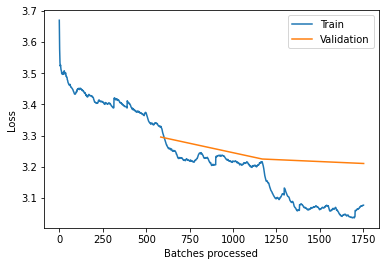

In [89]:
learn.recorder.plot_losses()

In [93]:
learn.save(model_path / '10kgnad_fine_tuned_lm')
learn.save_encoder(model_path / '10kgnad_fine_tuned_lm_enc')

## Evaluation: Text Generation

In [103]:
TEXT = "Keine"
N_WORDS = 50
N_SENTENCES = 2

In [105]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Keine Fähre soll Flüchtlinge in den Gewässern zwischen Calais und Calais bringen . Rom – Die italienische Küstenwache hat am Dienstag Airlines und Boote in der Nähe von Sizilien evakuiert . Die Höhle sei von einer
Keine neue Zeile für Satire . Nachdem Microsoft einen Artikel für seinen eigenen Blog veröffentlicht hat , haben die Nutzer zumindest dieses Update für den Versand von Facebook - Kontakten genutzt : So hat es sich bei Facebook
